In [2]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
from jax import random
from flax.training import train_state
from jax.experimental.ode import odeint

import time

# RELOADING MODULES
import importlib
import neural_net_pyomo
import matplotlib.pyplot as plt

importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

# UTILS DIRECTORY
import sys
import os
collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))

if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative

import non_parametric_collocation 
importlib.reload(non_parametric_collocation)
collocate_data = non_parametric_collocation.collocate_data

import data_generation 
importlib.reload(data_generation)
generate_ode_data = data_generation.generate_ode_data

In [ ]:
from scipy.integrate import solve_ivp

## `Toy dataset check`

In [3]:
def create_delayed_embeddings(x, tau, m):
    # Total length of the time series
    n = x.shape[0]
    
    # Initialize an empty list to store the embedding vectors
    embeddings = []
    
    # Loop over the time series to create each embedding vector
    # Only go up to points where a full embedding can be created
    for i in range(n - (m - 1) * tau):
        # Create the embedding vector by slicing the array
        embedding = jnp.array([x[i + j * tau] for j in range(m)])
        embeddings.append(embedding)
    
    # Convert list of embeddings to a Jax array
    return jnp.vstack(embeddings)

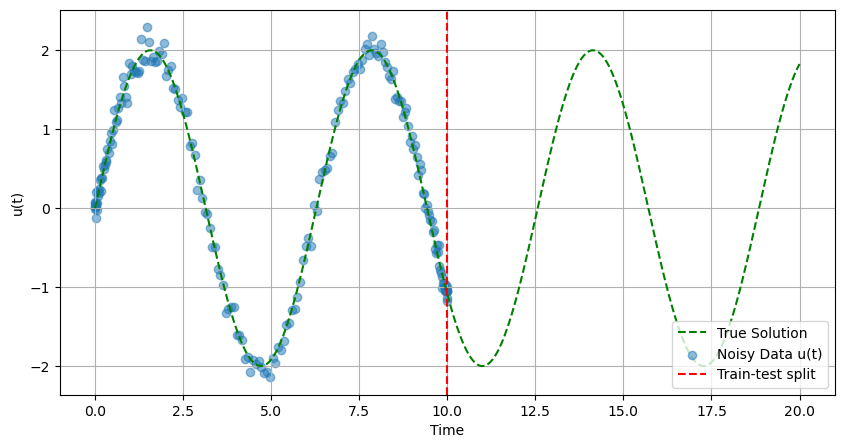

In [178]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "sinusoidal_oscillator", {"A": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t, y, y_noisy, true_derivatives = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy = np.array(jnp.squeeze(y_noisy))
t = np.array(jnp.squeeze(t))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights = compute_weights(t)
D = np.array(lagrange_derivative(t, weights))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test, y_test, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative, estimated_solution = collocate_data(y_noisy, t, 'EpanechnikovKernel', bandwidth=0.5)

plt.figure(figsize=(10, 5))
plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.scatter(t, y_noisy.T, label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [179]:
u = np.atleast_2d(y_noisy).T
r, c = u.shape
print(f"r : {r}; c : {c}")

u_estimated = np.atleast_2d(estimated_solution).T
r, c = u_estimated.shape
print(f"r : {r}; c : {c}")

r : 200; c : 1
r : 200; c : 1


In [250]:
importlib.reload(neural_net_pyomo)
NeuralODEPyomo = neural_net_pyomo.NeuralODEPyomo

In [251]:
def create_delayed_embeddings(x, tau, m):
    n = x.shape[0]  # Total length of the time series
    
    embeddings = []  # Initialize an empty list to store the embedding vectors
    
    for i in range(n - m * tau):  # Adjusted range to avoid including the last data point
        embedding = jnp.array([x[i + j * tau, 0] for j in range(m)])  # Create embedding vector
        embeddings.append(embedding)
    
    return jnp.vstack(embeddings)

# Example usage:
tau = 1
m = 1
embeddings = create_delayed_embeddings(y, tau, m)
print("Embedding shape:", embeddings.shape)

Embedding shape: (199, 1)


In [259]:
embeddings = np.array(embeddings)
embeddings.shape

(199, 1)

In [260]:
n = 200
layer_widths = [m+1, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, 
          #"hessian_approximation": 'limited-memory', 
          #'mu_strategy': 'adaptive', 
          #"dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'
          }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[m:], t[m:], D[m:, m:],
                           layer_widths, max_iter = 1000, act_func = "tanh", 
                           y_init = u_estimated, penalty_lambda = 0.01, extra_input=embeddings,
                           w_init_method = 'xavier', params = params
                           ) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes
tol=1e-08
print_level=5
constr_viol_tol=1e-05
compl_inf_tol=1e-05
check_derivatives_for_naninf=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    55440
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16240

Total number of variables............................:      280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      280
  

In [261]:
o = np.squeeze(y_pred_train.T)
o.shape

(199,)

In [262]:
t_new = t[m:]

In [263]:
def system_dynamics(t, y, embeddings, t_new):
    # Assume embeddings is interpolated or otherwise handled to match t
    # embeddings, t_all = args

    current_index = np.searchsorted(t_new, t, side='right') - 1
    #print(current_index)
    
    input = np.array([y[0], embeddings[current_index][0]])
    du_dt = ode_model.predict(input)  # Assume ode_model.predict works with numpy arrays
    print(du_dt[0])
    
    return du_dt

initial_conditions = np.array(u[m])

t_span = (t_new[0], t_new[-1])
# Run the solver
sol = solve_ivp(system_dynamics, t_span, initial_conditions, t_eval=t_new, args=(embeddings,t_new))

# Access solution
y_pred_train = sol.y
t_points = sol.t

# If you need to calculate MAE or similar metrics
#mae_train = np.mean(np.abs(y_pred_train - true_y))

0.3334772449334072
0.33679223446625006
0.2868312784627067
0.1951091779368667
-0.21639670635760386
-0.38805316996395683
-0.6123470347815384
-0.4054062567629513
0.3354441167917066
0.284407964629714
0.028674142619954386
-0.04143778044235961
-0.03708043549365606
0.06305006035347735
-0.12046320379428396
-0.1322849014019375
-0.3402668898059168
-0.2248553546527052
-0.535882721281426
-0.7171616166658342
-0.12183587614866745
-0.12992000598660253
-0.3416334770722815
-0.25744749188692373
-0.28351723879473073
-0.40660691367530666
-0.42522628088030007
-0.43549460359154346
-0.7595004799213606
-0.7522197993705784
-0.7843921609979645
-0.8118555071267805
-0.8480897206843713
-1.1799179029375186
-1.5295799633812224
-1.947786564980916
-1.921459229920962
-1.3963180207060337
-1.8053614743218582
-1.8524974698123893
-1.9949927676414925
-1.9122767372074192
-1.9690996199516335
-2.134591724063286
-2.630792793937448
-2.710896095248977
-2.9940918003192967
-2.9082698582809616
-3.00706022744593
-3.217805731672021
-3

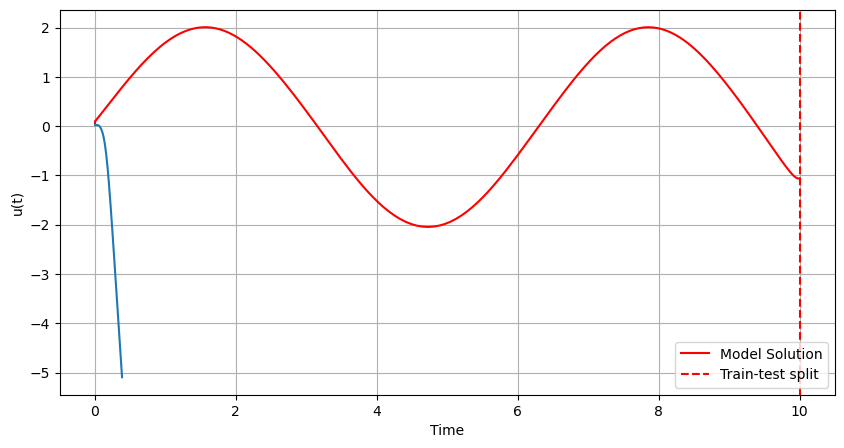

In [264]:
i = 25
y_model = ode_model.extract_solution().T

plt.figure(figsize=(10, 5))
plt.plot(t[m:], np.squeeze(y_model), 'r', label='Model Solution')
#plt.plot(t_test, y_test, 'g--', label='True Solution')
plt.plot(t_new[:i], o[:i])

#plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [166]:
y_model = ode_model.extract_solution().T
current_index = 0

def system_dynamics(y, t, args):
    
    t_all, delayed_embeddings = args
    # map = t_all == t
    current_index = jnp.argwhere(t_all == t)[0][0]
    
    input = jnp.array([y[0], delayed_embeddings[current_index][0]])
    current_index +=1 
    # will have to pass in: jnp.array([y[0], delayed_embeddings])
    # the delayed embeddings will be the embeddings of the previous time steps
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

# intial condition adjusted to the first value of the data 
# where an embedding can be created
initial_conditions = jnp.array([u[m:][0]]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t[m:], (t[m:], embeddings))    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

"""y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print(f"Test MAE: {mae_test}")"""

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[].
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [155]:
from jax import lax

def single_step(carry, x):
    y, embeddings = carry
    current_index = x  # In this setup, x will be the current index directly
    input = jnp.array([y[0], embeddings[current_index][0]])
    du_dt = ode_model.predict(input)
    next_y = y + du_dt * step_size  # Simplified Euler integration
    return (next_y, embeddings), next_y


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float64[1,1].
The error occurred while tracing the function step_fun at /var/folders/2v/gfm3z1tn5fj8zss_r9hrgnv80000gn/T/ipykernel_6724/2476745993.py:3 for scan. This concrete value was not available in Python because it depends on the value of the argument i.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [153]:


#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
# plt.plot(t_test[N-1:], y_pred_test, 'b--', label='Predicted Solution', alpha = 0.5)

plt.plot(t[:n], np.squeeze(y_model), 'r', label='Model Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int64[].
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

### If `t` is passed as a parameter

In [13]:
n = 200
layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
params = {"tol":1e-8, "print_level": 5, "hessian_approximation": 'limited-memory', 
          'mu_strategy': 'adaptive', "dual_inf_tol": 1e-5, 
          "constr_viol_tol": 1e-5, "compl_inf_tol": 1e-5,
          "check_derivatives_for_naninf": 'yes'
          }

start_timer_build = time.time()
ode_model = NeuralODEPyomo(u[:n], t[:n], D[:n, :n], layer_widths, max_iter = 1000, act_func = "tanh", y_init = u_estimated, penalty_lambda = 0.01, time_invariant=False) # , extra_input = t

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y
Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    55919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16321

Total number of variables............................:      281
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      281
                     variables with only upper bounds:        0
Total number of equality constraints.

Train MAE: 0.04505121447437138
Test MAE: 11.324000661414786


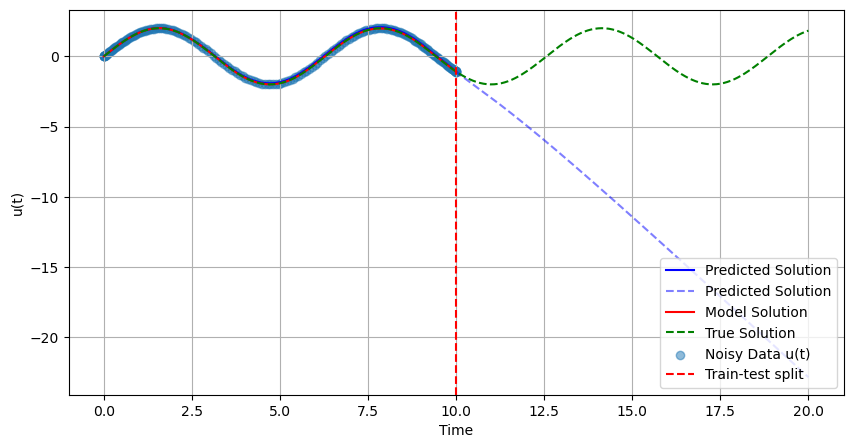

In [15]:
y_model = ode_model.extract_solution().T

def system_dynamics(y, t):
    input = jnp.array([y[0], t])
    du_dt = ode_model.predict(input)
    return jnp.array([du_dt])

initial_conditions = jnp.array([0.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y))
print (f"Train MAE: {mae_train}")

y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test[N-1:]))
print(f"Test MAE: {mae_test}")

#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(10, 5))
plt.plot(t, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test[N-1:], y_pred_test, 'b--', label='Predicted Solution', alpha = 0.5)

plt.plot(t[:n], np.squeeze(y_model), 'r', label='Model Solution')
plt.plot(t_test, y_test, 'g--', label='True Solution')

plt.scatter(t[:n], y_noisy.T[:n], label='Noisy Data u(t)', alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Fails to predict beyond the train set

## 2D Example Working

In [9]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_ho_cheb = compute_weights(t_ho_cheb)
D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [10]:
layer_widths = [2, 10, 2]

params = {'tol': 1e-8, 'halt_on_ampl_error': 'yes'}
start_timer_build = time.time()
ode_model = NeuralODEPyomo(y_noisy_ho_cheb, t_ho_cheb, D_ho_cheb, layer_widths, max_iter = 1000, act_func = "tanh", w_init_method = 'xavier', params = params, y_init = estimated_solution_ho_cheb) # , y_init = estimated_solution_ho_cheb

ode_model.build_model()
end_timer_build = time.time()

result = ode_model.solve_model()

y_model = ode_model.extract_solution()

def system_dynamics(y, t):
    input = jnp.array([y[0], y[1]])
    du_dt, dv_dt = ode_model.predict(input)
    return jnp.array([du_dt, dv_dt])

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_neural_nets_1d_sin/neural_net_pyomo.py:68: UserWarning: y_init should be structured such that each row represents a new time point.
  warnings.warn("y_init should be structured such that each row represents a new time point.")


Ipopt 3.14.16: max_iter=1000
halt_on_ampl_error=yes
tol=1e-08


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    96316
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    20641

Total number of variables............................:      452
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      452
                     variables with only upper bounds:        0
Total number of equality cons

In [11]:
initial_conditions = jnp.array([0.0, 1.0]) 
y_pred_train = odeint(system_dynamics, initial_conditions, t_ho_cheb)    
mae_train = jnp.mean(jnp.abs(y_pred_train - y_ho_cheb))
print (f"Train MAE: {mae_train}")


y1 = y_pred_train[-1, :]
y_pred_test = odeint(system_dynamics, y1, t_test_ho_cheb[N-1:])
mae_test = jnp.mean(jnp.abs(y_pred_test - y_test_ho_cheb[N-1:]))
print (f"Test MAE: {mae_test}")

Train MAE: 0.020154443323591124
Test MAE: 0.023739105296246593


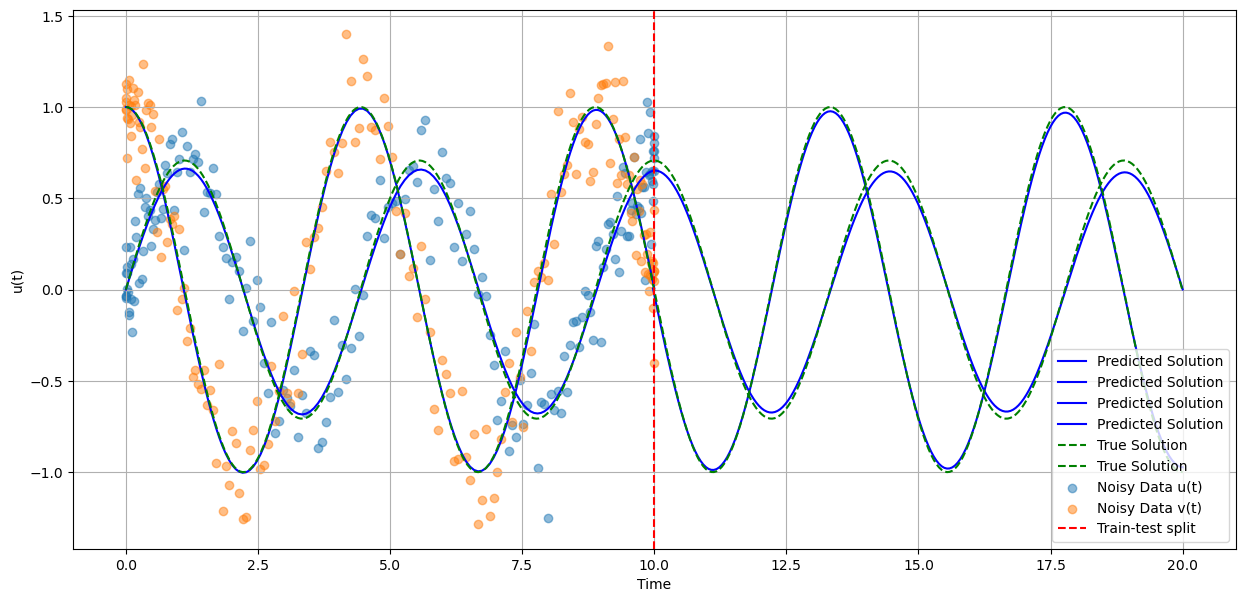

In [12]:
#---------------------------PLOTTING RESULTS--------------------------#
plt.figure(figsize=(15, 7))
plt.plot(t_ho_cheb, y_pred_train, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb[N-1:], y_pred_test, 'b', label='Predicted Solution')
plt.plot(t_test_ho_cheb, y_test_ho_cheb, 'g--', label='True Solution')
plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[0], label='Noisy Data u(t)', alpha = 0.5)

plt.scatter(t_ho_cheb, y_noisy_ho_cheb.T[1], label='Noisy Data v(t)', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('u(t)')
plt.axvline(x=end_time, color='r', linestyle='--', label='Train-test split')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()